In [51]:
import requests
import os 
import datetime

import vertexai
from vertexai.generative_models import GenerativeModel, ChatSession

project_id = "fourth-webbing-420020"
location = "us-central1"
vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")

def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    response = chat.send_message(prompt, stream=False)
    return response.text

In [52]:
with open ('sites.txt') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]
f.close()

In [53]:
# manual div class keywords
keywords = ["event", "content", "detail", "card", "views","location","time", "date", "notes", "evt"]

# previous 10 years
years = [str(i) for i in range(2010, datetime.datetime.now().year)]

# all monnth in title case
old_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
index_of_month = old_months.index(datetime.datetime.now().strftime("%B"))
old_months = old_months[:index_of_month]

# list of sites needing selenium scraping
js_sites = {6:"EventCard_event__kHN5V",7:"card__detail",4:"s-lc-mc-evt",9:"spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe",1:"trumba.spud.5.iframe"}

### Main Functions


In [54]:

# Custom HTML Parsing as solution vs. LLM Text Extraction w/ HTML Filtering
import bs4
import requests
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

"""
1. Retrieve HTML from a site
1.1 Retrieve HTML from a site using Selenium
2. Extract event text from HTML
2.5 Preprocess Event Text
3. Store event text in a file
4. Convert to JSON or CSV via LLM
5. Store in a database

"""

# 1 - Retrieve HTML from a site
def get_html(site):
    response = requests.get(site)
    if response is None:
        print('Failed to retrieve html from site')
        return None
    return response.text

# 1.1 - Retrieve HTML from a site using Selenium
def get_html_selenium(site, id, site_dict):
    driver = webdriver.Chrome()
    driver.get(site)
    time.sleep(2)
    element = None
    target_element = site_dict[id]
    
    button_element = "//a[text()='WEEK' and @role='button']"
    iframes = driver.find_elements("id",'trumba.spud.3.iframe')
    button_iframe = "trumba.spud.3.iframe"
    
    if len(iframes) > 0:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, button_iframe)))
        print("Found IFRAME")
        driver.switch_to.frame(button_iframe)
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, button_element)))
        print("Found Button")
        element.click()
        time.sleep(2)
        driver.switch_to.default_content()
    
    if ".iframe" in target_element:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, target_element))
        )
        driver.switch_to.frame(target_element)
        print("Found IFRAME")
        time.sleep(5)
        
    else:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CLASS_NAME, target_element))
        )

    html = driver.page_source
    driver.quit()
    return html

# --------------------------------------------------------------------------------------------

# 2 - Extract event text from HTML
def extract_event_text(soup):
    all_divs = soup.find_all('div')
    lowercase_all_divs_classes(all_divs)
    # event_divs = filter_event_divs(all_divs)
    # event_divs = all_divs
    event_text = extract_text_from_event_divs(all_divs)
    print(f"Before Removing Duplicates {len(event_text)}")
    event_text = filter_event_text(event_text)
    print(f"After Removing Duplicates {len(event_text)}")
    return event_text

def extract_span_text(soup):
    all_spans = soup.find_all('span')
    lowercase_all_divs_classes(all_spans)
    # event_spans = filter_event_divs(all_spans)
    event_text = extract_text_from_event_divs(all_spans)
    return event_text

# 2.5 - Preprocess Event Text
def lowercase_all_divs_classes(divs):
    for div in divs:
        if div.has_attr('class'):
            div['class'] = [x.lower() for x in div['class']]

# TODO: Validate if this is correct
# ! Does shorten down html file, but sometimes fails to capture everything
# ! Token limit is 32,000 so it is fine for now
# def filter_event_divs(all_divs):
#     event_divs = []
#     for div in all_divs:
#         if div.get('class') is not None and any(keyword in div.get('class')[0] for keyword in keywords):
#             event_divs.append(div)
#     return event_divs

# heuristic filter for after line extraction
# if the 4 lines before and after don't have numbers, it is not an event
def filter_event_text(event_text):
    indexes_to_remove = []

    for index, line in enumerate(event_text):
        if index < 3 or index > len(event_text) - 4:
            continue
        
        if any(char.isdigit() for char in line):
            continue
        
        count = 0
        for i in range(3):
            if any(char.isdigit() for char in event_text[index - i]) or any(char.isdigit() for char in event_text[index + i]):
                break
            count += 1
        if count == 3:
            indexes_to_remove.append(index)
            
    print(indexes_to_remove)
    return [event_text[i] for i in range(len(event_text)) if i not in indexes_to_remove]
    

def extract_text_from_event_divs(event_divs):
    event_text = []
    for div in event_divs:
        text = div.get_text()
        text = [x for x in text.split('\n') if x != '']
        for line in text:
            if is_old_event(line):
                continue
            while '\n' in line:
                line = line.replace('\n', ' ')
            event_text.append(line + '\n')
    return event_text

def is_old_event(line):
    if any(year in line for year in years):
        return True
    elif any(month in line for month in old_months):
        return True
    return False

def remove_duplicates(event_text):
    return list(set(event_text))

# --------------------------------------------------------------------------------------------


# 3 - Store event text in a file
def write_event_text(event_text, filename):
    event_text = [x.encode('ascii', 'ignore').decode('ascii') for x in event_text]
    folder = "extracted_txt"
    file_path = folder + "/" + filename
    with open(file_path, 'w') as f:
        for event in event_text:
            if len(event) > 0 or event != ' ':
                f.write(event)
    f.close()
    return 0

def test_write_event_text(event_text, filename):
    event_text = [x.encode('ascii', 'ignore').decode('ascii') for x in event_text]
    print(f"After Removing Duplicates {len(event_text)}")
    folder = "test_extractions_txt"
    file_path = folder + "/" + filename
    with open(file_path, 'w') as f:
        for event in event_text:
            if len(event) > 0 or event != ' ':
                f.write(event)
    f.close()
    return 0
# --------------------------------------------------------------------------------------------

# 4 - Convert to JSON or CSV via LLM
def convert_to_json(site_index):
    input_text = """ 
    Convert this text to JSON for events with this schema:
    Event:
    - Title: The name of the event 
    - Start Time: Has to be 1 value
    - End Time: Has to be 1 value
    - Date: (Month, Day) of the event 
    - Location: Where the event takes place 
    
    Store the objects in a JSON array without duplicate entries.
    Close numbers like 911am should be split to 9am and 11am.
    """
    filename = f'site_{site_index}.txt'
    with open(f'extracted_txt/{filename}') as f:
        site_text = f.read()
    input_text += site_text
    
    chat = model.start_chat()
    response = get_chat_response(chat, input_text)
    
    output = response
    while "`" in output:
        output = output.replace("`", "")
    output = output.replace("JSON", "")
    output = output.replace("json", "")
    
    with open(f'event_jsons/site_{site_index}.json', 'w') as f:
        f.write(output)
    f.close()
    
    return 0

# --------------------------------------------------------------------------------------------

# 5 - Read JSON and store in a database
def read_json(site_index):
    with open(f'event_jsons/site_{site_index}.json') as f:
        event_json = f.read()
    f.close()
    return event_json

# X - Store as a CSV for now

# --------------------------------------------------------------------------------------------


def single_site(site):
    html = get_html(site)
    print(html)
    soup = bs4.BeautifulSoup(html, 'html.parser')
    event_text = extract_event_text(soup)
    write_event_text(event_text, 'site.txt')
    convert_to_json(1)
    print(len(event_text))
    print(event_text)
    return 0

def single_site_js(site, id, site_dict):
    html = get_html_selenium(site, id, site_dict)
    print(html)
    soup = bs4.BeautifulSoup(html, 'html.parser')
    event_text = extract_event_text(soup)
    write_event_text(event_text, 'site.txt')
    convert_to_json(1)  
    print(len(event_text))
    print(event_text)
    return 0

def process_sites():
    for i, site in enumerate(lines):
        print(f"Processing site {site}")

        if i in js_sites:
            html = get_html_selenium(site, i, js_sites)
        else:
            html = get_html(site)

        soup = bs4.BeautifulSoup(html, 'html.parser')
        event_text = extract_event_text(soup)
        write_event_text(event_text, f'site_{i}.txt')
        convert_to_json(i)

        print(f"Finished processing site {i}")
        # # gemini pro free can only process 2 requests per minute
        # time.sleep(30)
    return 0

In [55]:
process_sites()

Processing site https://scholarslab.lib.virginia.edu/events/
Before Removing Duplicates 203
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194]
After Removing Duplicates 104
Finished processing site 0
Processing site https://www.virginia.edu/calendar
Found IFRAME
Found Button
Found IFRAME
Before Removing Duplicates 266
[]
After Removing Duplicates 266
Finished processing site 1
Processing site https://education.virginia.edu/events
Before Removing Duplicates 2602
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45

InvalidArgument: 400 Input request contains (44571) tokens, which is more than the max tokens limit allowed: (32760)

### Json Playground

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def update_year(value):
    if pd.isna(value):
        return value
    return value.replace(year=2024)

def convert_to_datetime(value):
    new_value = value
    
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    
    while "." in new_value:
        new_value = new_value.replace('.', '')
        
    for fmt in ('%I:%M%p', '%I:%M %p', '%I%p', '%I %p'):
        try:
            return pd.to_datetime(new_value, format=fmt)
        except ValueError:
            pass
    return new_value

def edit_time(value):
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    
    times = str.split(value, ':')
    hour = int(times[0])
    if hour > 12:
        hour -= 12
        return str(hour) + ':' + times[1] + ' pm'
    if hour < 10:
        return value + ' pm'
    else:
        return value + ' am'

In [ ]:
listdir_names_list = os.listdir('event_jsons')

In [ ]:
all_events = []
event_dfs = []
nan_dfs = []
discard_dfs = []
for file in os.listdir('event_jsons'):
    # TODO: Add the department of the event
    with open(f'event_jsons/{file}') as f:
        text = json.load(f)
    f.close()
    for event in text:
        all_events.append(event)
        
    df = pd.DataFrame(text)
    nan_df = df[df["Date"].isna()]
    df["Date"] = pd.to_datetime(df["Date"], format='%B %d', errors='coerce').apply(update_year)
    discard_df = df[df["Date"] < datetime.datetime.now()]
    df = df[df["Date"] >= datetime.datetime.now()]
    df["Start Time"] = df["Start Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    df["End Time"] = df["End Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    df.drop_duplicates(subset=['Title'], inplace=True)
    event_dfs.append(df)
    nan_dfs.append(nan_df)
    discard_dfs.append(discard_df)

In [ ]:
all_events_df = pd.concat(event_dfs)
all_events_df.reset_index(drop=True, inplace=True)

nan_df = pd.concat(nan_dfs)
nan_df.reset_index(drop=True, inplace=True)

discard_df = pd.concat(discard_dfs)
discard_df.reset_index(drop=True, inplace=True)

print(f'Total Events {nan_df.shape[0] + all_events_df.shape[0]}')
print(f'Discarded Events {discard_df.shape[0]}')

Total Events 73
Discarded Events 14


In [ ]:
missing_end_time_rows = all_events_df["End Time"].isna()
new_end_time_values = all_events_df.loc[missing_end_time_rows, "Start Time"] - datetime.timedelta(hours=1)
all_events_df.loc[missing_end_time_rows, "End Time"] = new_end_time_values

# set both start and etime column dtypes to dt
all_events_df["Start Time"] = pd.to_datetime(all_events_df["Start Time"])
all_events_df["End Time"] = pd.to_datetime(all_events_df["End Time"])

all_events_df["Start Time"] = all_events_df["Start Time"].dt.strftime('%I:%M %p')
all_events_df["End Time"] = all_events_df["End Time"].dt.strftime('%I:%M %p')

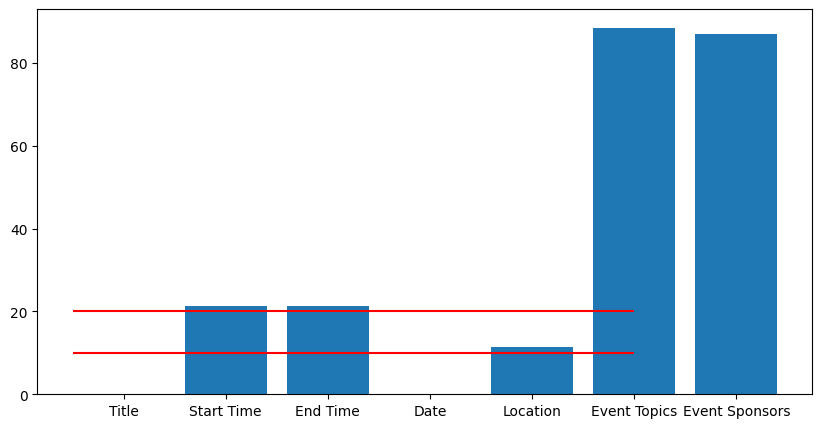

In [ ]:
# sum isna
isna = all_events_df.isna().sum()
rows = all_events_df.shape[0]
isna_percent = isna / rows * 100
plt.figure(figsize=(10, 5))
plt.bar(isna_percent.index, isna_percent)
plt.hlines(20, -.5, 5, colors='r')
plt.hlines(10, -.5, 5, colors='r')

#### 20% from comm and architecture school, bad html scraping job

In [ ]:
all_events_df.to_csv('allevents_csv/all_events.csv', index=False)
nan_df.to_csv('allevents_csv/nan_events.csv', index=False)

### LLM Playground

In [2]:
import vertexai
from vertexai.generative_models import GenerativeModel, ChatSession

# TODO(developer): Update and un-comment below lines
project_id = "fourth-webbing-420020"
location = "us-central1"
vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)

prompt = "Hello."
print(get_chat_response(chat, prompt))

prompt = "What are all the colors in a rainbow?"
print(get_chat_response(chat, prompt))

prompt = "Why does it appear when it rains?"
print(get_chat_response(chat, prompt))

Hello, there! How can I assist you today?
The colors in a rainbow, in order, are:

1. Red
2. Orange
3. Yellow
4. Green
5. Blue
6. Indigo
7. Violet

You can remember the order of the colors with the acronym ROYGBIV.
A rainbow is caused by sunlight interacting with raindrops in the atmosphere. When sunlight hits a raindrop, it is refracted (bent) and reflected inside the raindrop. The light is then refracted again as it exits the raindrop, and the different colors of light are separated out because they are refracted at different angles.

For a rainbow to form, the sun must be behind the observer and the raindrops must be in front of the observer. The sun's rays must also be able to reach the raindrops at a specific angle. This is why rainbows are typically seen in the sky opposite the sun, and why they are often seen after a rainstorm, when there are still plenty of raindrops in the air.

The size of the raindrops also affects the appearance of the rainbow. Smaller raindrops produce bri

In [10]:
input_text = """ 
    Convert this text to JSON for events with this schema:
    Event:
    - Title: The name of the event 
    - Start Time: Has to be 1 value
    - End Time: Has to be 1 value
    - Date: (Month, Day) of the event 
    - Location: Where the event takes place 
    
    Store the objects in a JSON array without duplicate entries.
    Close numbers like 911am should be split to 9am and 11am.
    Exclude '''JSON''' in the text.
"""

# print the length of input text after being added upon for each site text
cost_per_1000 = 0.000125
total_cost = 0
for i in range(len(lines)):
    with open(f'extracted_txt/site_{i}.txt') as f:
        site_text = f.read()
    f.close()
    site_text += input_text
    input_length = len(site_text)
    print(f"Site {i} Length: {len(site_text)}")
    print(f"Cost: ${cost_per_1000 * (input_length / 1000)}")
    total_cost += cost_per_1000 * (input_length / 1000)
print(f"Total Cost: ${total_cost}")

Site 0 Length: 2507
Cost: $0.000313375
Site 1 Length: 7417
Cost: $0.000927125
Site 2 Length: 15204
Cost: $0.0019005
Site 3 Length: 3257
Cost: $0.00040712500000000004
Site 4 Length: 1721
Cost: $0.000215125
Site 5 Length: 34398
Cost: $0.004299750000000001
Site 6 Length: 3474
Cost: $0.00043425
Site 7 Length: 689
Cost: $8.612499999999999e-05
Site 8 Length: 9840
Cost: $0.00123
Site 9 Length: 4402
Cost: $0.0005502500000000001
Site 10 Length: 28200
Cost: $0.003525
Site 11 Length: 30336
Cost: $0.003792
Total Cost: $0.017680625000000002


### Test Functions

In [ ]:
import unittest

class TestEventExtraction(unittest.TestCase):
    def setUp(self):
        self.html = """
        <html>
            <body>
                <div class="event">Event 1</div>
                <div class="content">Content 1</div>
                <div class="detail">Detail 1</div>
                <div class="card">Card
                <div class="views">Views 1</div>
                <div class="location">Location 1</div>
        </html>
        """
        self.soup = bs4.BeautifulSoup(self.html, 'html.parser')
        self.all_divs = self.soup.find_all('div')
    
    def test_lowercase_all_divs_classes(self):
        lowercase_all_divs_classes(self.all_divs)
        for div in self.all_divs:
            if div.has_attr('class'):
                self.assertTrue(all(x.islower() for x in div['class']))
    
    def test_filter_event_divs(self):
        event_divs = filter_event_divs(self.all_divs)
        self.assertTrue(all(any(keyword in div.get('class')[0] for keyword in keywords) for div in event_divs))
    
    def test_is_old_event(self):
        old_event = "Event from 2010"
        self.assertTrue(is_old_event(old_event))
                
    def test_extract_html(self):
        site = 'https://www.google.com'
        html = get_html(site)
        self.assertIsNotNone(html)
        
    def test_extract_selenium_html(self):
        site = 'https://www.virginia.edu/calendar'
        id = 1
        site_dict = {4:"s-lc-mc-evt",9:"spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe",1:"trumba.spud.5.iframe"}
        html = get_html_selenium(site, id, site_dict)
        self.assertIsNotNone(html)
                
    
    
unittest.main(argv=[''], exit=False)

.

Found IFRAME


....
----------------------------------------------------------------------
Ran 5 tests in 17.421s

OK


In [43]:
def test_parsings(sites):
    for id, site in enumerate(sites):
        if id in js_sites:
            html = get_html_selenium(site, id, js_sites)
        else:
            html = get_html(site)
        soup = bs4.BeautifulSoup(html, 'html.parser')
        event_text = extract_event_text(soup)
        test_write_event_text(event_text, f'site_{id}.txt')
        print(len(event_text), site)
        
    return 0 

In [57]:
# test list_set for the extracted_txt files
for i in range(len(lines)):
    with open(f'extracted_txt/site_{i}.txt') as f:
        site_text = f.read()
    f.close()
    site_text = site_text.split('\n')
    print(f"Site {i} Length: {len(site_text)}")
    site_text = list(set(site_text))
    # join with \n
    site_text = '\n'.join(site_text)
    print(f"Site {i} Length: {len(site_text)}")
    write_event_text(site_text, f'site_{i}.txt')

Site 0 Length: 1
Site 0 Length: 565
Site 1 Length: 1
Site 1 Length: 16694
Site 2 Length: 1
Site 2 Length: 3534
Site 3 Length: 1
Site 3 Length: 2270
Site 4 Length: 1
Site 4 Length: 9891
Site 5 Length: 1
Site 5 Length: 2750
Site 6 Length: 1
Site 6 Length: 12054
Site 7 Length: 1
Site 7 Length: 2070
Site 8 Length: 1
Site 8 Length: 5956
Site 9 Length: 1
Site 9 Length: 4004
Site 10 Length: 1
Site 10 Length: 5687
Site 11 Length: 1
Site 11 Length: 6152


In [50]:
test_parsings(lines)

Before Removing Duplicates 203
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194]
After Removing Duplicates 104
After Removing Duplicates 104
104 https://scholarslab.lib.virginia.edu/events/
Found IFRAME
Found Button
Found IFRAME
Before Removing Duplicates 266
[]
After Removing Duplicates 266
After Removing Duplicates 266
266 https://www.virginia.edu/calendar
Before Removing Duplicates 2602
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 68, 78, 79

0